In this notebook, SCOOT data (cycle level and 15min) is compared with the video counts done **on the same day at the same location**, with the goal of comparing the precision and accuracy of cycle level and aggregate data.

All plots in the notebook represent counts on 2017-04-19.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pg import DB
import configparser
import warnings
warnings.simplefilter('error',RuntimeWarning)
from scoot_utilities import *

In [2]:
# Database connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [3]:
# Set up
# Set up the centrelines and detectors in the scope of this analysis
centrelines = [3304786,446523,30018925,30018925,1147201,1147201,1147026,1147466,8540609,8571185,11466484,1141946]
dir_bins = [1,-1,1,-1,1,-1,1,1,1,-1,1,-1]
sdetectors = [['\'N12921J1\'','\'N12921J2\''],['\'N12931A1\'','\'N12931A2\''],['\'N12821C1\'','\'N12821C2\'','\'N12821C3\''],['\'N12851G1\'','\'N12851G2\''],['\'N30431K1\'','\'N30431K2\''],['\'N30421B1\'','\'N30421B2\''],['\'N30611K1\'','\'N30611K2\''],['\'N30311D1\'','\'N30311D2\''],['\'N21521K1\''],['\'N21521H1\''],['\'N21421D1\''],['\'N21311B1\'']]
locations = ['Don Mills NB N of Overlea','Don Mills SB S of Gateway','Don Mills NB N of Clock Tower','Don Mills SB S of Lawrence','Lake Shore EB E of Stadium','Lake Shore WB W of Bathurst','Lake Shore EB E of Spadina','Lake Shore EB E of Ontario Place','Bloor EB W of Castle Frank','Bloor WB E of Castle Frank','Bloor EB E of Church','Bloor WB W of Church']
aggregation = [[['lane1','lane2'],['lane3']],
               [['lane1','lane2'],['lane3']],
               [['lane1'],['lane2'],['lane3']],
               [['lane2','lane3'],['lane1']],
               [['lane1','lane2'],['lane3']],
               [['lane3'],['lane1','lane2']],
               [['lane1'],['lane2','lane3']],
               [['lane1'],['lane2','lane3']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']]]
det_lane = {'N12921J1':2,'N12921J2':1,'N12931A1':2,'N12931A2':1,'N12821C1':1,'N12821C2':1,'N12821C3':1,
                 'N12851G1':2,'N12851G2':1,'N30431K1':2,'N30431K2':1,'N30421B1':1,'N30421B2':2,'N30611K1':1,
                 'N30611K2':2,'N30311D1':1,'N30311D2':2,'N21521K1':2,'N21521H1':2,'N21421D1':2,'N21311B1':2}

In [4]:
# Retrieve Data from the database
scoot_disagg = pd.DataFrame(db.query('SELECT * FROM scoot.cycle_level_170419 WHERE detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), \
                            columns = ['count_date','count_time','detector','CycleTime','Volume','occupancy','seconds'])
video = pd.DataFrame(db.query('SELECT * FROM scoot.video_counts').getresult(), \
                     columns = ['time_start','time_end','lane1','lane2','lane3','Volume','centreline_id','dir_bin','count_date','seconds'])
video['CycleTime'] = 20
scoot_agg = pd.DataFrame(db.query('SELECT detector, start_time, flow_mean, EXTRACT(HOUR FROM start_time)*3600 + EXTRACT(MINUTE FROM start_time)*60 AS seconds  FROM scoot.agg_15_201704 WHERE start_time::date = \'2017-04-19\' AND detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), \
                         columns = ['detector', 'count_time', 'Volume', 'seconds'])
scoot_agg['Volume'] = scoot_agg['Volume']//4

In [6]:
# Parameters
# Video counts do not start until 15min into the day. will report error if 00:00:00 is entered as start time
start_hour = 0
start_min = 15
start_sec = 0
end_hour = 23
end_min = 59
end_sec = 59

offsets = [0,0,0,0,0,0,0,0,0,0,0,0]
bin_sec = 900

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
num_bins = (end_time_sec - start_time_sec)//bin_sec
min_bins_start_15 = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
bins = [x//bin_sec for x in min_bins_start_15]
bins = bins[:-1]

Don Mills NB N of Overlea


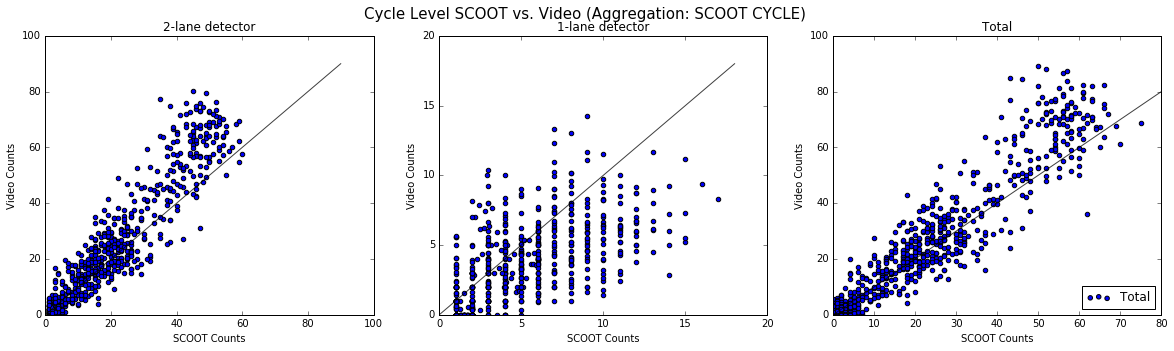

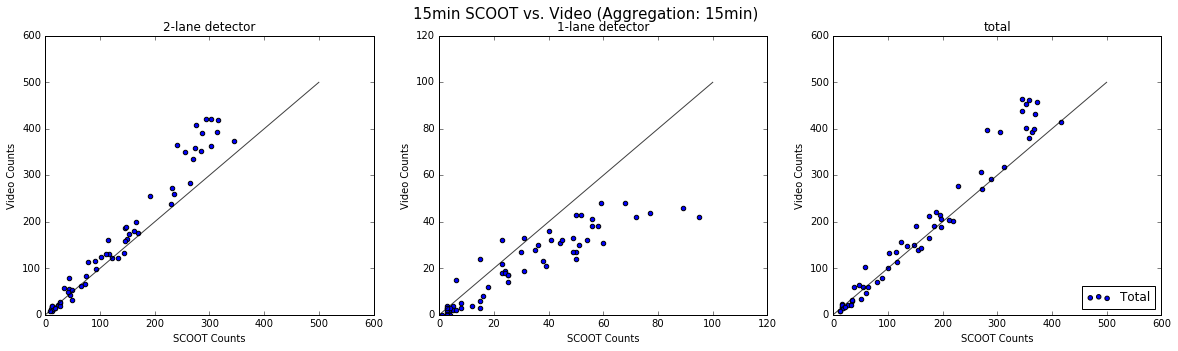

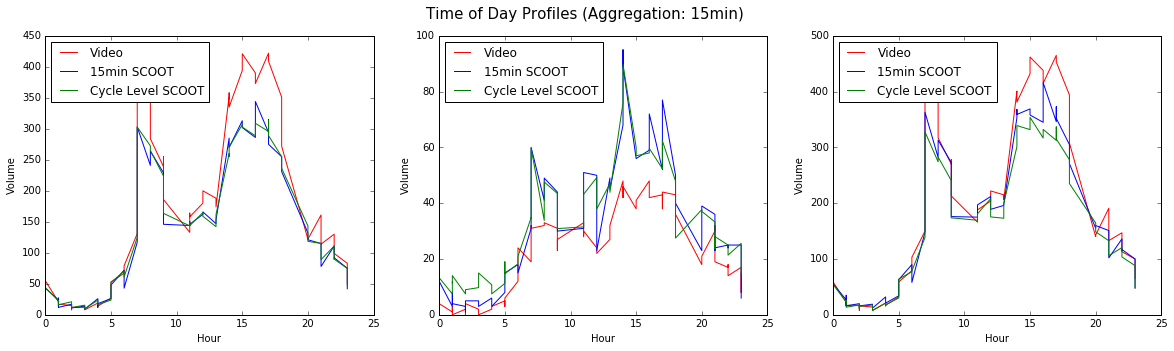

Don Mills SB S of Gateway


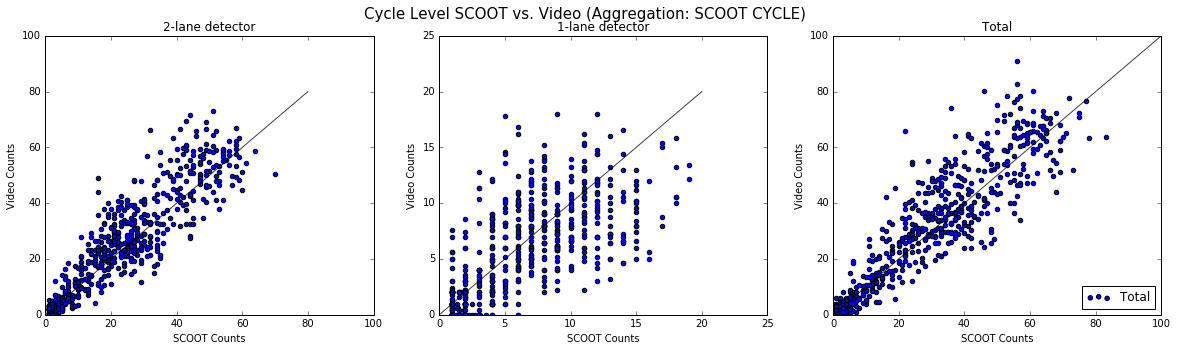

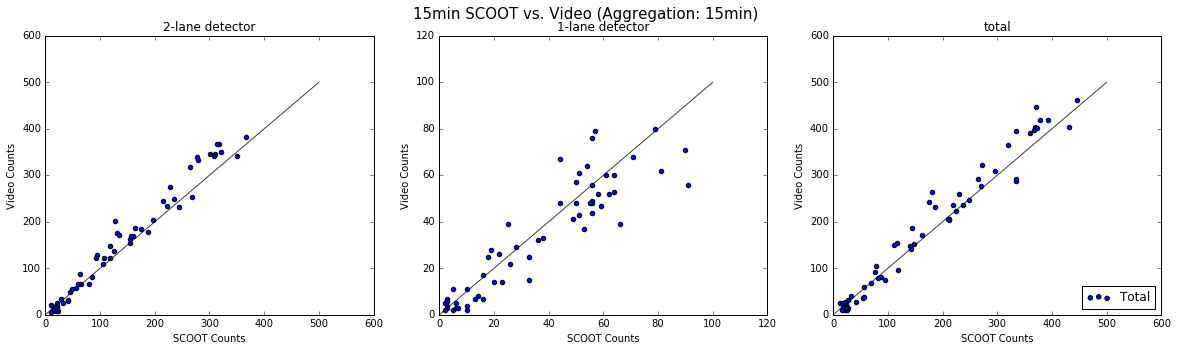

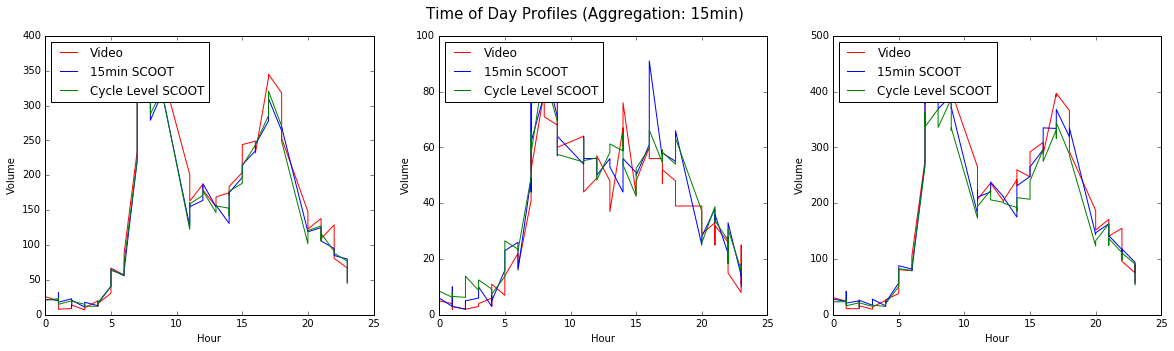

Don Mills NB N of Clock Tower


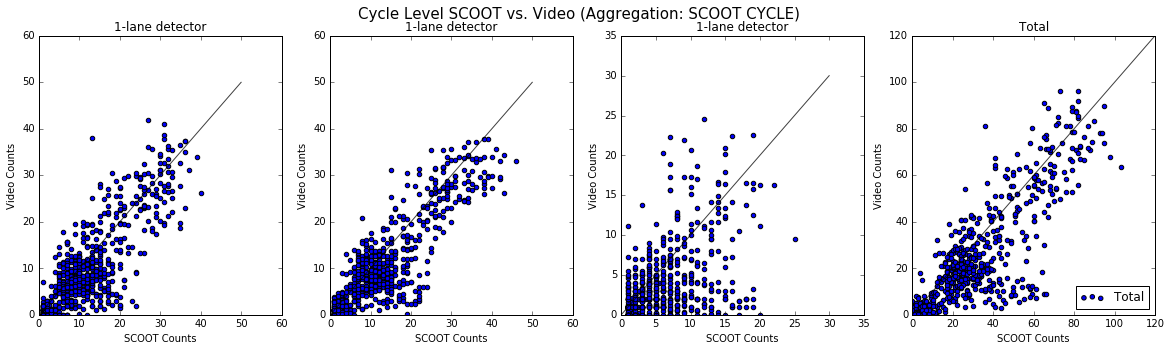

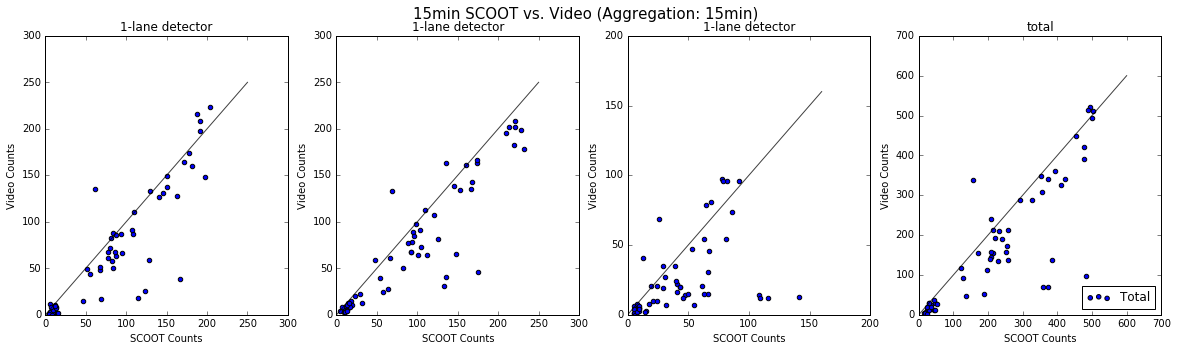

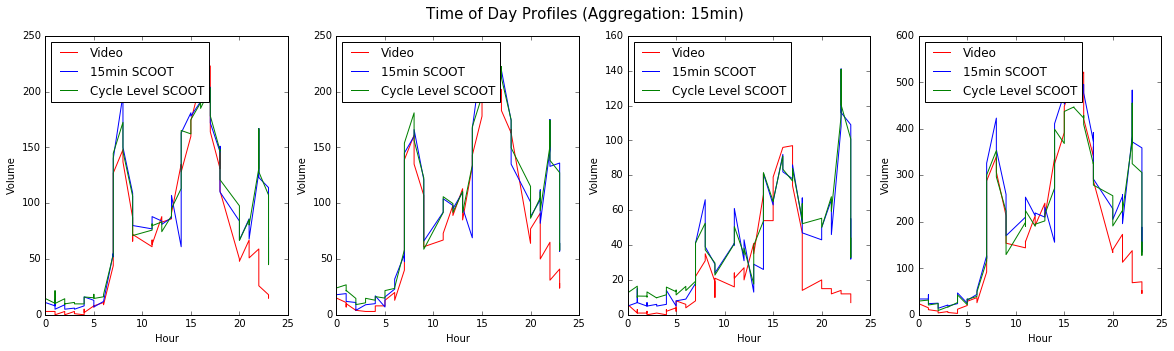

Don Mills SB S of Lawrence


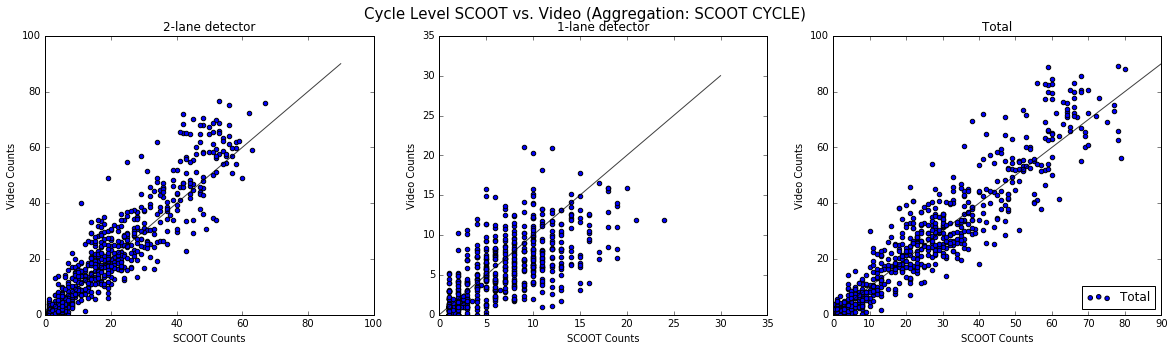

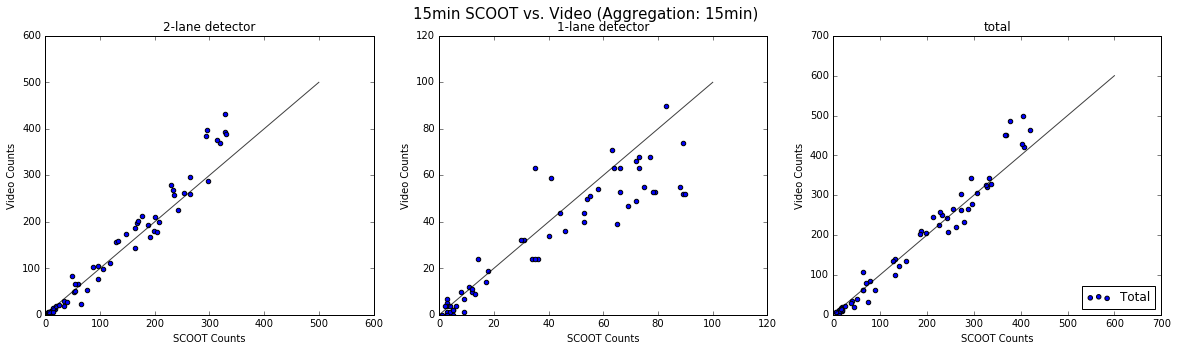

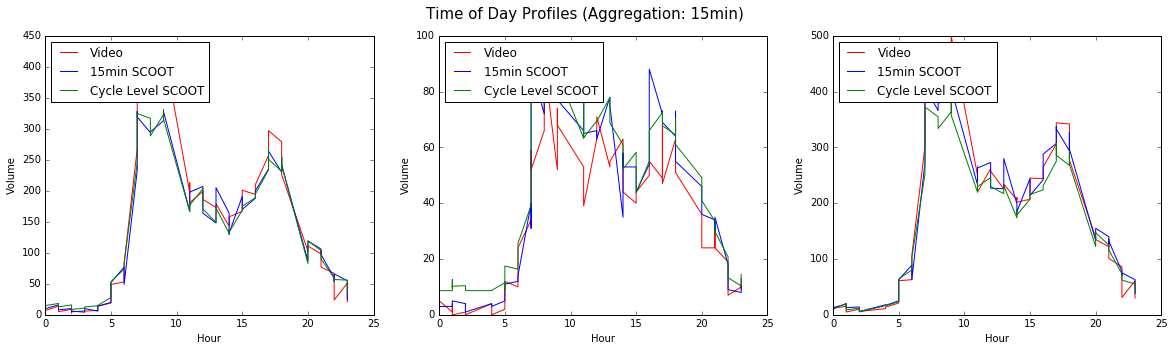

Lake Shore EB E of Stadium


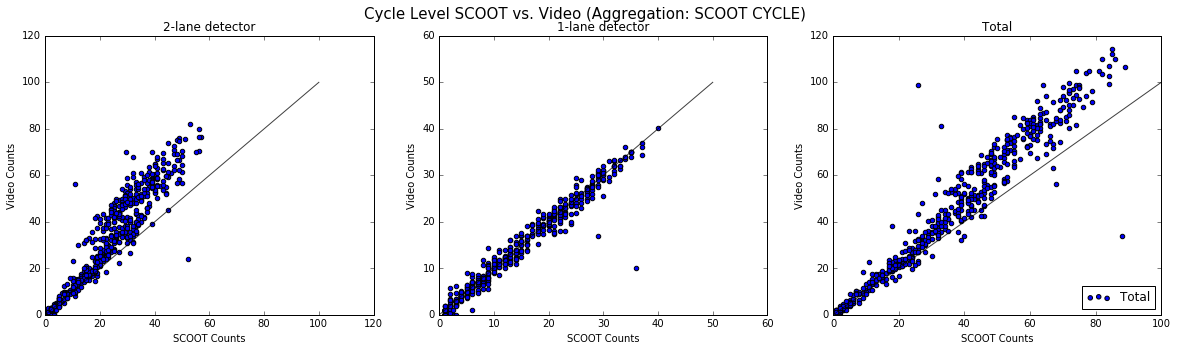

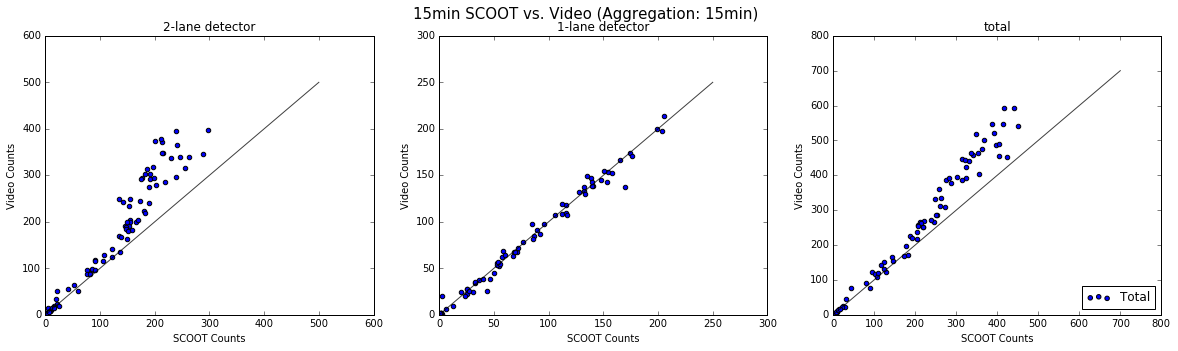

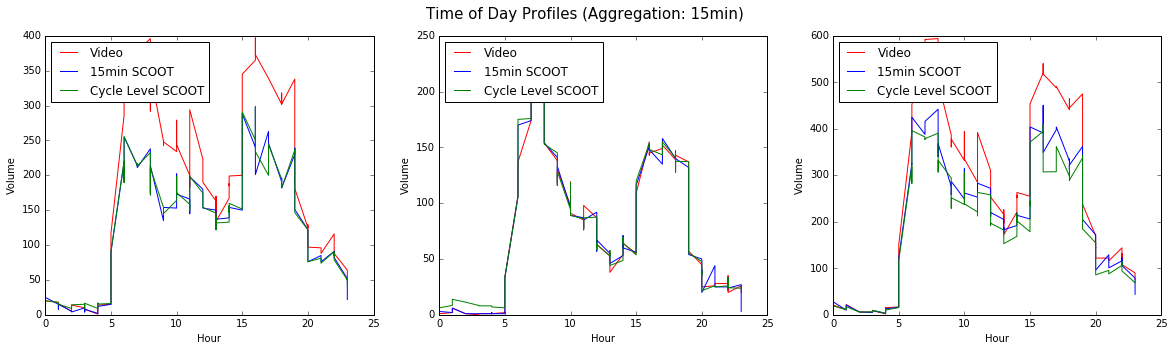

Lake Shore WB W of Bathurst


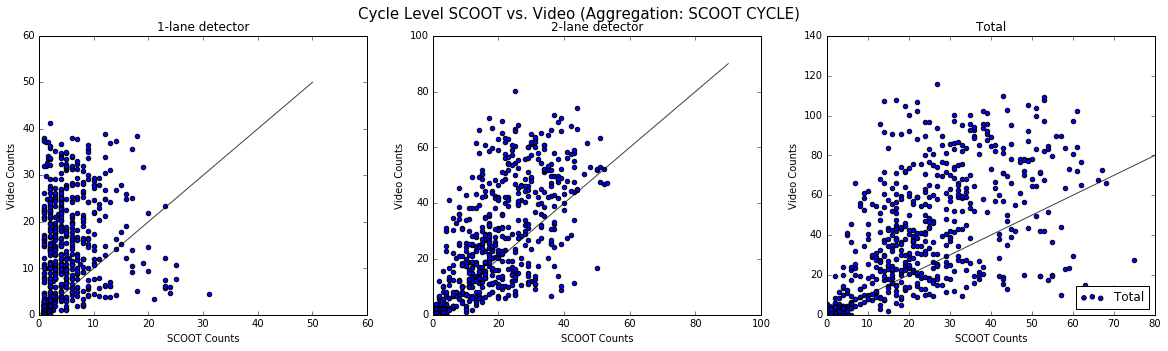

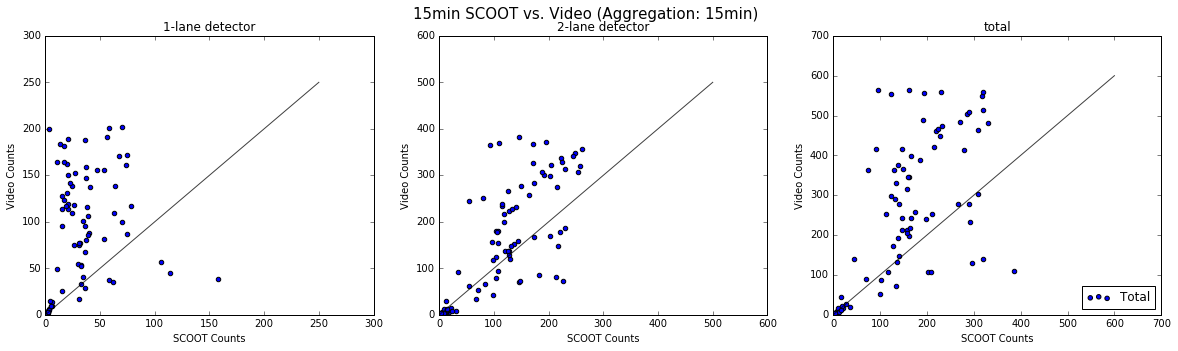

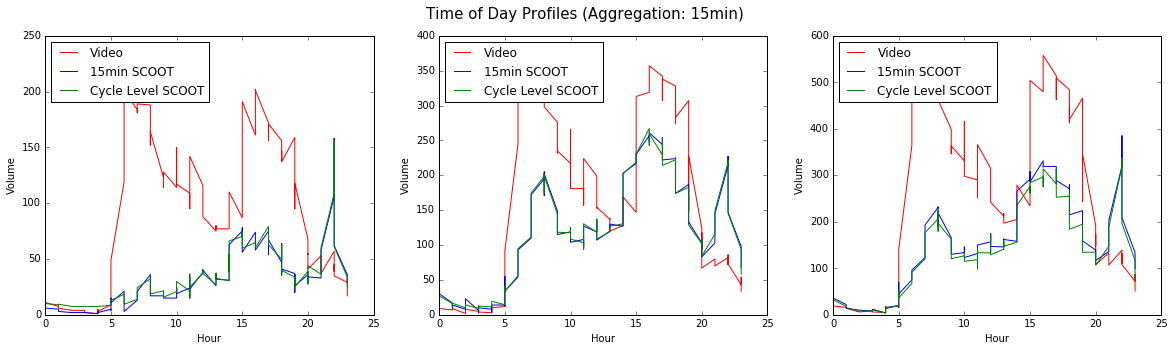

Lake Shore EB E of Spadina


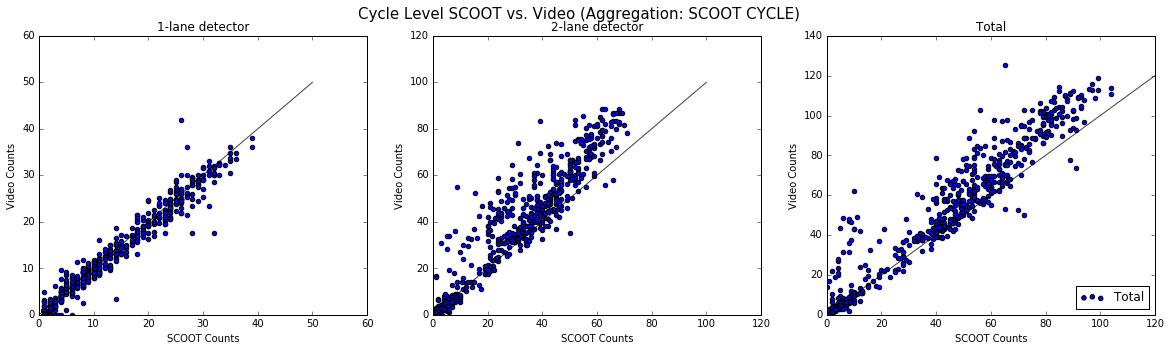

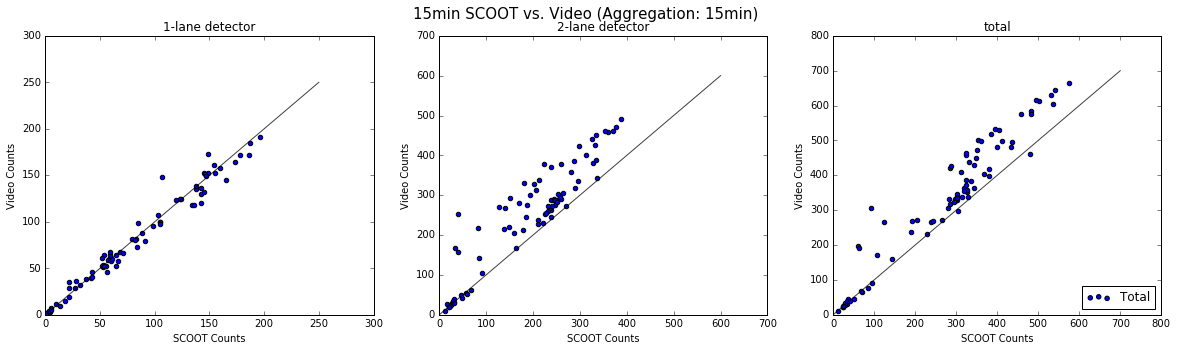

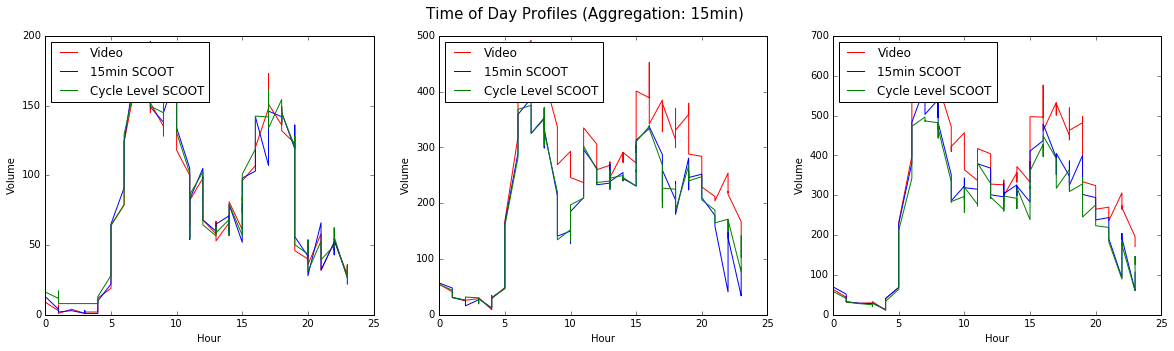

Lake Shore EB E of Ontario Place


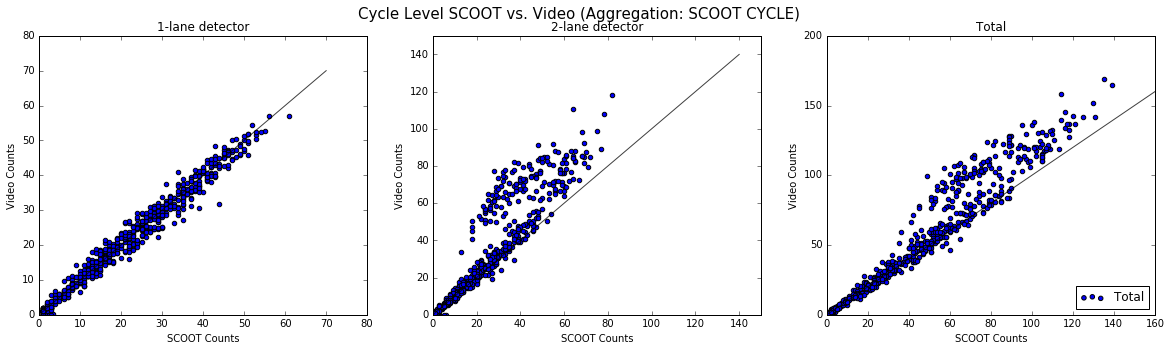

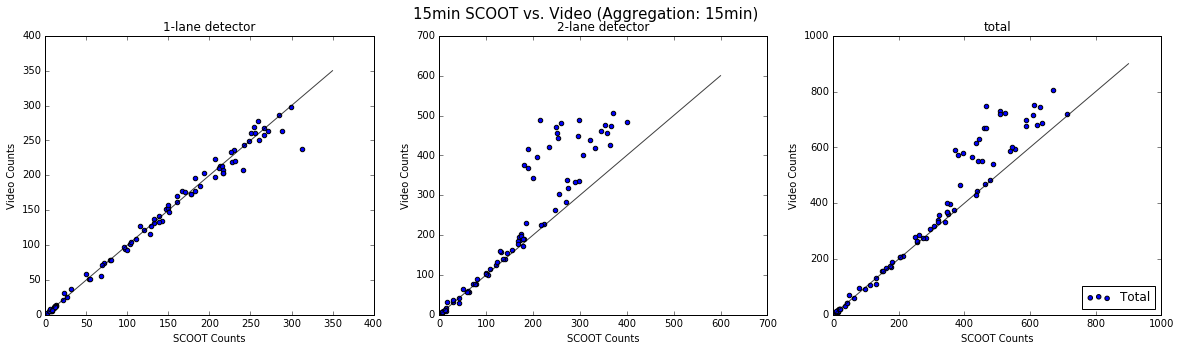

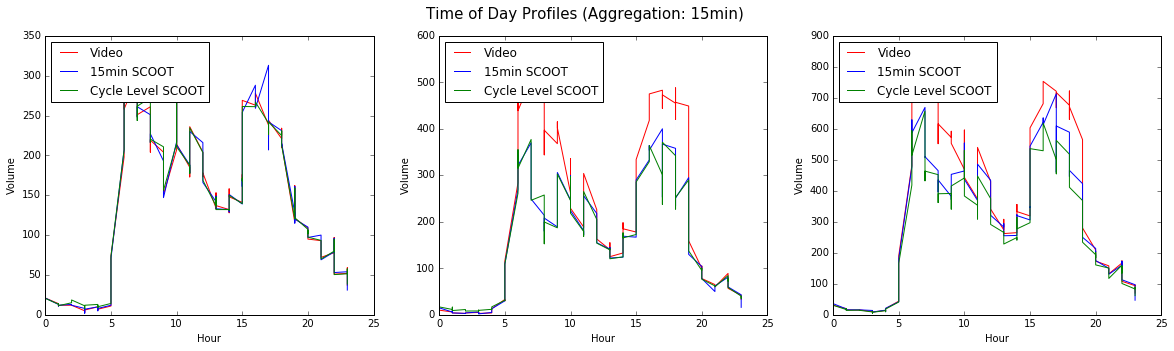

Bloor EB W of Castle Frank


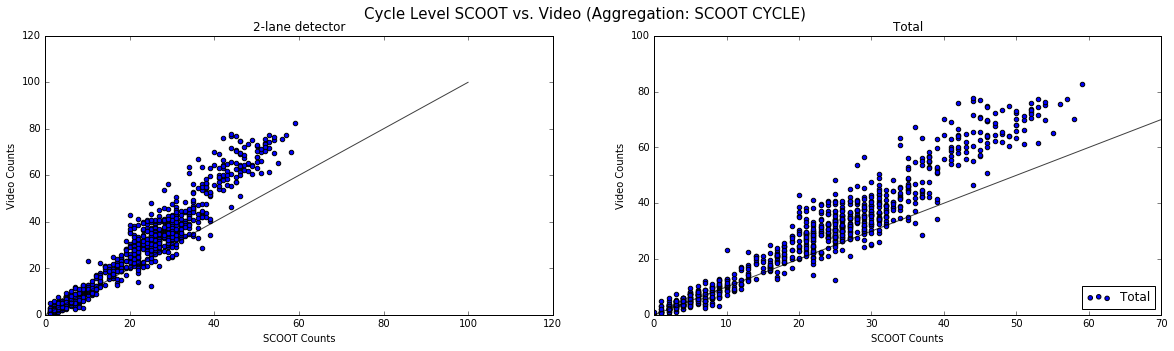

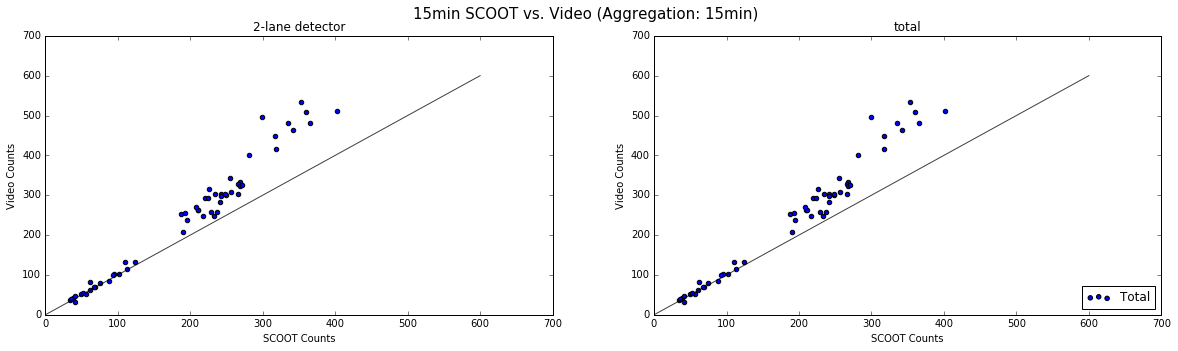

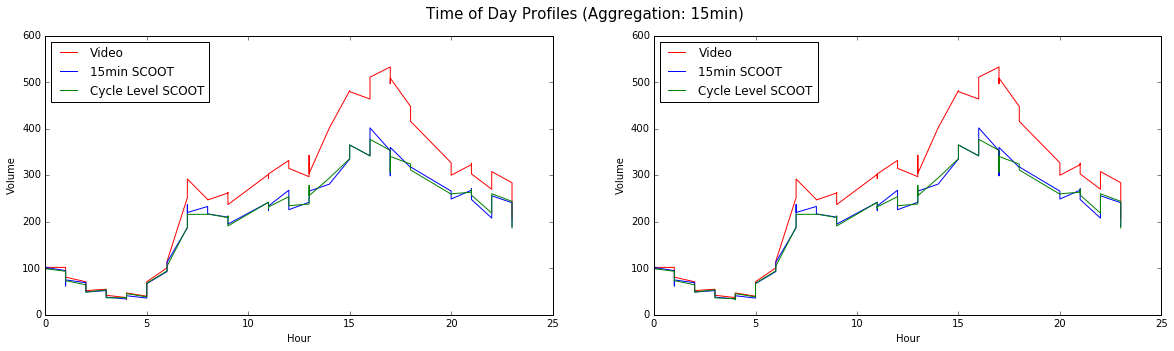

Bloor WB E of Castle Frank


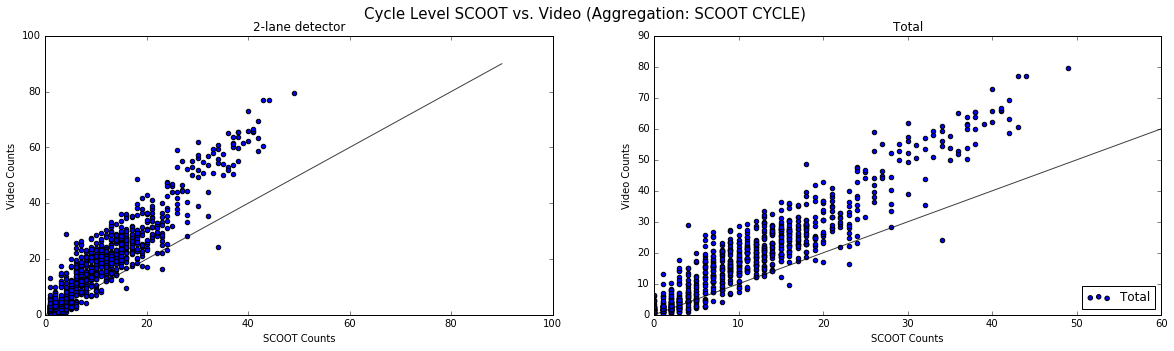

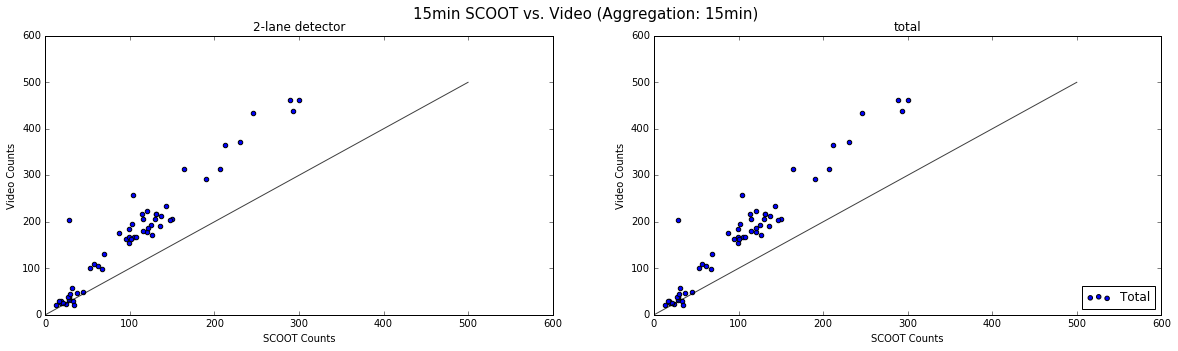

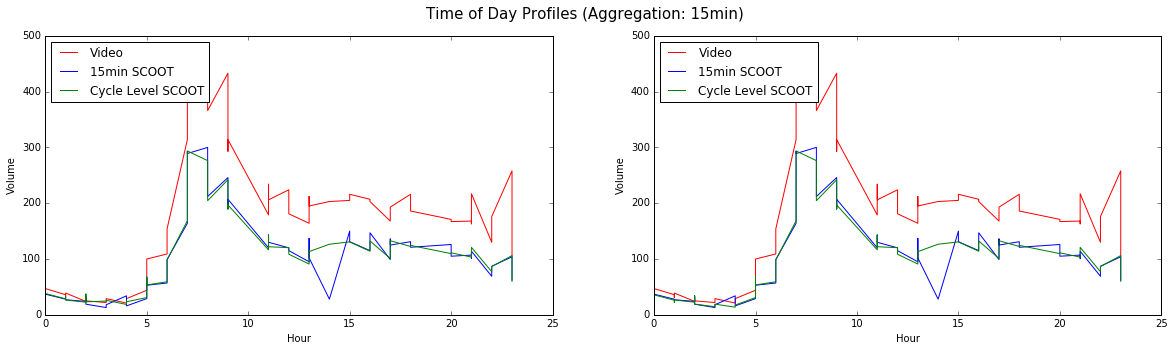

Bloor EB E of Church


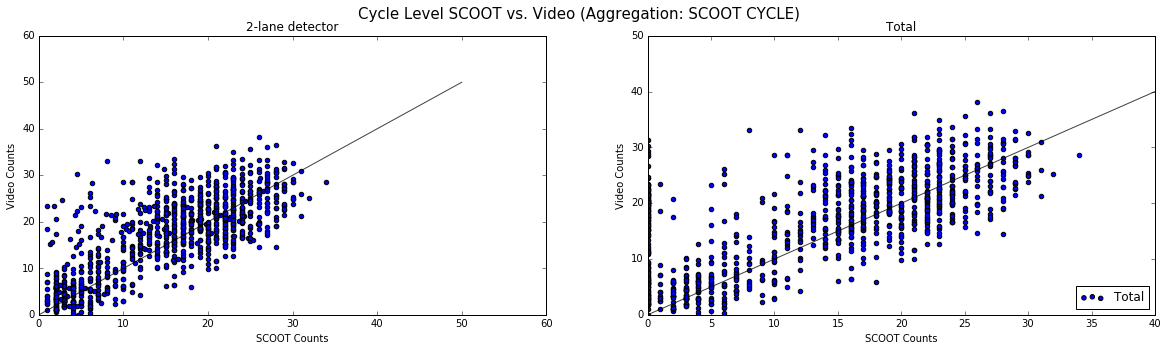

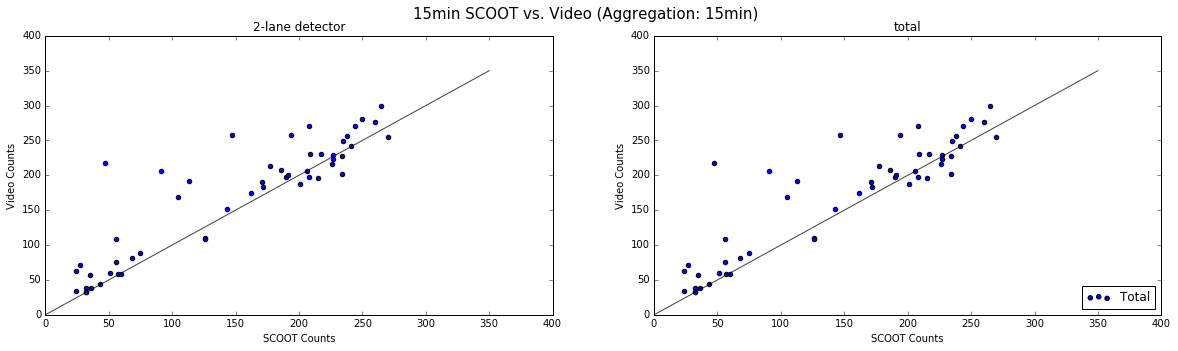

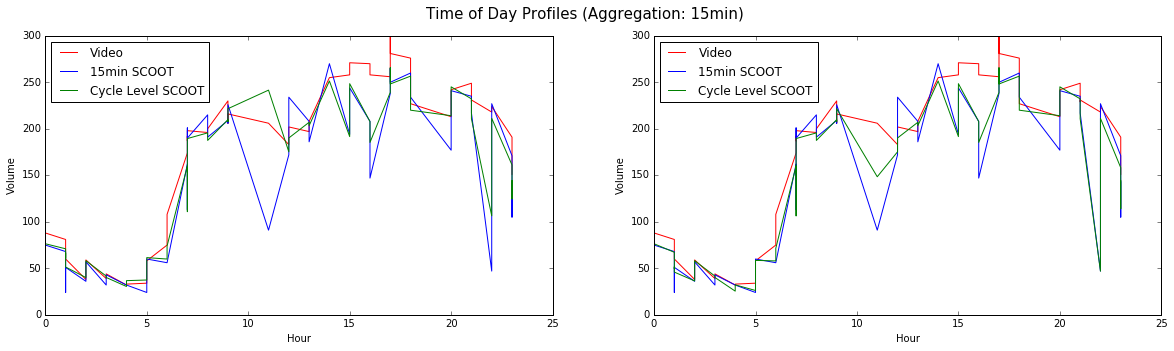

Bloor WB W of Church


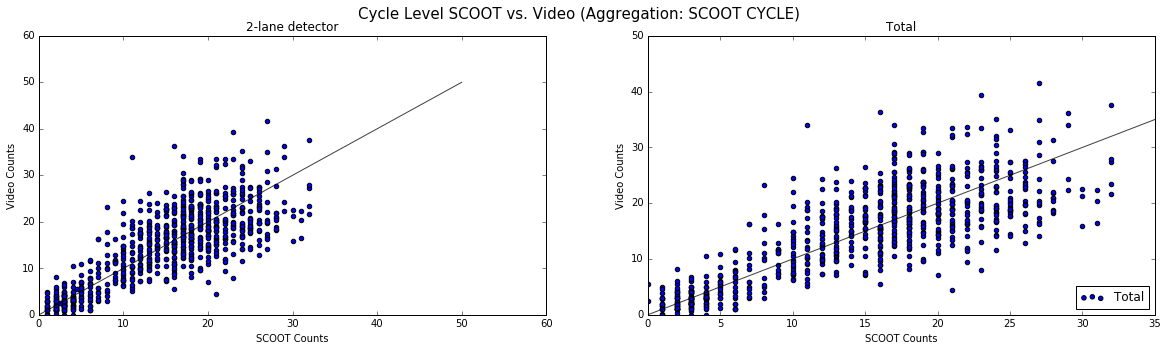

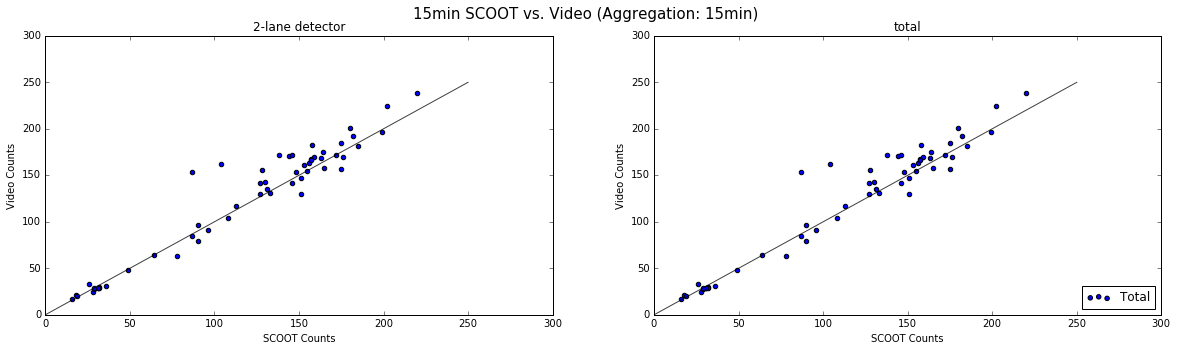

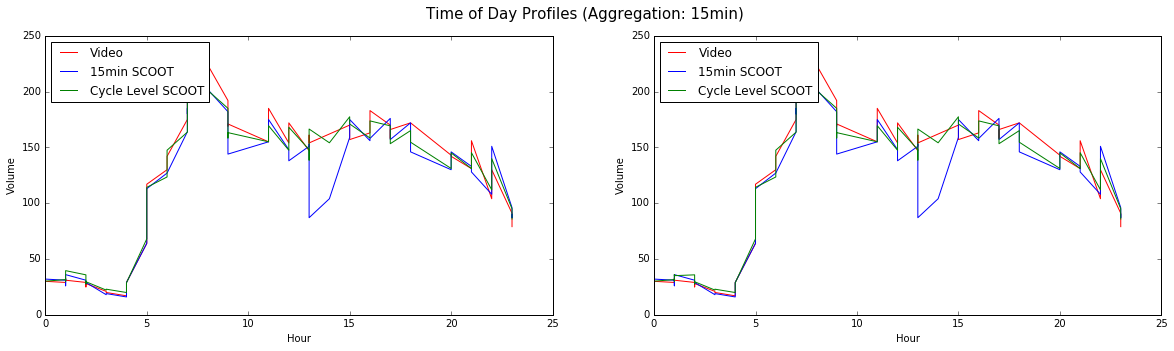

In [9]:
for i in range(len(locations)):
    RSS = []
    sdet = [x.strip('\'') for x in sdetectors[i]]
    tcl = centrelines[i]
    dir_bin = dir_bins[i]
    offset = offsets[i]
    iterables = []
    
    print(locations[i])

    # Time Filter 
    s_d = scoot_disagg[(scoot_disagg['seconds']>=start_time_sec) & (scoot_disagg['seconds']+scoot_disagg['CycleTime']<=end_time_sec)].copy()
    s_d = s_d[s_d['detector'].isin([x.strip('\'') for x in sdet])]
    
    r = video[(video['seconds']>=start_time_sec-offset) & (video['seconds']<=end_time_sec-offset) & (video['centreline_id']==tcl) & (video['dir_bin']==dir_bin)].copy()
    r['bin'] = r['seconds']//bin_sec
    
    s_a = scoot_agg[(scoot_agg['seconds']>=start_time_sec) & (scoot_agg['seconds']+900<=end_time_sec)].copy()
    s_a = s_a[s_a['detector'].isin([x.strip('\'') for x in sdet])]
    
    # Aggregate lanes to individual detectors
    r = aggregate_lanes(r, aggregation[i])
    
    # Offset video counts
    r['seconds']=r['seconds']+offset

    # Reset Index
    s_d.reset_index(inplace=True, drop=True)
    r.reset_index(inplace=True, drop=True)
    s_a.reset_index(inplace=True, drop=True)
    
    # Create Figures
    fig,(ax) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # disaggregate vs video
    fig_a,(ax_a) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # aggregate vs video
    fig_tod, (ax_tod) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # time of day plots
    fig.suptitle('Cycle Level SCOOT vs. Video (Aggregation: SCOOT CYCLE)', fontsize=15)
    fig_a.suptitle('15min SCOOT vs. Video (Aggregation: 15min)', fontsize=15)
    fig_tod.suptitle('Time of Day Profiles (Aggregation: 15min)', fontsize=15)
    
    # Plot Individual Detectors
    for det in range(len(sdet)):
        # Disaggregate vs. Video
        s0_d = s_d[s_d['detector'] == sdet[det]].copy()
        
        # Validity Check
        if len(s0_d[s0_d['Volume'] != 0]) < 0.5*len(s0_d):
            print('Too Few Valid counts')
            continue
        
        # Get the timestamps of each bin
        min_bins_start = list(s0_d['seconds'])
        min_bins_start.append(s0_d['seconds'].values[-1]+s0_d['CycleTime'].values[-1])
        
        # Interpolate the missing values
        s1_d = fill_in_linear(list(s0_d['Volume']))
        # Aggregate video counts to scoot cycle level
        v = aggregate_data(min_bins_start, r, 'detector'+str(det))

        # Plot
        ax[det].scatter(s1_d, v, label=None)
        add_y_eq_x(ax[det])
        ax[det].set_title(str(det_lane[sdet[det]]) + '-lane detector')
        ax[det].set_ylabel('Video Counts')
        ax[det].set_xlabel('SCOOT Counts')
        ax[det].set_xlim(xmin = 0)
        ax[det].set_ylim(ymin = 0)
        
        # 15min Aggregate vs. Video
        s0_a = s_a[s_a['detector'] == sdet[det]].copy()
        s0_a['bin'] = s0_a['seconds']//bin_sec
        v0_a = aggregate_data(min_bins_start_15, r, 'detector'+str(det))
        v0_a = pd.DataFrame({'bin':bins, 'v_v':v0_a})
        
        # Plot time bins with count
        vol = pd.merge(s0_a, v0_a, on='bin', how='inner', copy=False)
        vol = vol[vol['Volume']!=0]
        
        # Plot
        ax_a[det].scatter(vol['Volume'], vol['v_v'], label=None)
        add_y_eq_x(ax_a[det])
        ax_a[det].set_title(str(det_lane[sdet[det]]) + '-lane detector')
        ax_a[det].set_ylabel('Video Counts')
        ax_a[det].set_xlabel('SCOOT Counts')
        ax_a[det].set_xlim(xmin = 0)
        ax_a[det].set_ylim(ymin = 0)
        
        # Aggregate disaggregate data to 15min
        s0_d['Volume'] = s1_d
        s_d_a = aggregate_data(min_bins_start_15, s0_d, 'Volume')
        s_d_a = pd.DataFrame({'bin':bins, 's_d_a':s_d_a})
        vol = pd.merge(vol, s_d_a, on='bin', how='inner')
        
        # Plot
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['s_d_a'], label = 'Cycle Level SCOOT', color = 'g')
        ax_tod[det].set_ylabel('Volume')
        ax_tod[det].set_xlabel('Hour')
        ax_tod[det].set_xlim(xmin = 0)
        ax_tod[det].set_ylim(ymin = 0)
        ax_tod[det].legend(loc=2)
        
    det = det + 1
    
    # Plot Total
    # Disaggregate Total
    s_d = s_d.groupby(['seconds'], as_index=False).sum()
    min_bins_start = list(s_d['seconds'])
    min_bins_start.append(s_d['seconds'].values[-1]+s_d['CycleTime'].values[-1])
    v = aggregate_data(min_bins_start, r, 'Volume')
    
    ax[det].scatter(s_d['Volume'],v,label='Total')
    ax[det].set_ylabel('Video Counts')
    ax[det].set_xlabel('SCOOT Counts')
    ax[det].set_xlim(xmin = 0)
    ax[det].set_ylim(ymin = 0)
    ax[det].legend(loc=4)
    add_y_eq_x(ax[det])
    ax[det].set_title('Total')
    
    # Aggregate Total
    s_a = s_a[s_a['Volume']!=0]
    s_a = s_a.groupby(['seconds'], as_index=False).filter(lambda x: len(x) == len(sdet))
    s_a = s_a.groupby(['seconds'], as_index=False).sum()
    s_a['bin'] = s_a['seconds']//bin_sec
    v_a = aggregate_data(min_bins_start_15, r, 'Volume')
    v_a = pd.DataFrame({'bin':bins, 'v_v':v_a})
    vol = pd.merge(s_a, v_a, on='bin', how='inner')
    vol = vol[vol['Volume']!=0]
    ax_a[det].scatter(vol['Volume'], vol['v_v'], label = 'Total')
    ax_a[det].set_ylabel('Video Counts')
    ax_a[det].set_xlabel('SCOOT Counts')
    ax_a[det].legend(loc=4)
    add_y_eq_x(ax_a[det])
    ax_a[det].set_xlim(xmin = 0)
    ax_a[det].set_ylim(ymin = 0)
    ax_a[det].set_title('total')
    
    # TOD profile total
    s_d_a = aggregate_data(min_bins_start_15, s_d, 'Volume')
    s_d_a = pd.DataFrame({'bin':bins, 's_d_a':s_d_a})
    vol = pd.merge(vol, s_d_a, on='bin', how='inner')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['s_d_a'], label = 'Cycle Level SCOOT', color = 'g')
    ax_tod[det].set_ylabel('Volume')
    ax_tod[det].set_xlabel('Hour')
    ax_tod[det].set_xlim(xmin = 0)
    ax_tod[det].set_ylim(ymin = 0)
    ax_tod[det].legend(loc=2)
    
    plt.show()

# Observations

## Cycle level vs. Aggregate 15min
From time of day profiles, simple aggregations of the green (cycle level) agrees with 15min aggregations from the system (blue). Unless detailed information is needed, using 15min values for volume prediction is adequate.

SCOOT agggregate volume has big drops/gaps for several 15min periods for almost every detector/day. It is more reliable to linearly interpolate cycle level drops than to interpolate 15min drops. Therefore, a good use of the cycle-level data is to validate and complement the 15min aggregate measure, as empty count bins occurs quite frequently in scoot aggregate data. 

Aggregate 15min SCOOT generally stay closer to the y=x line than cycle level. Possible reason is that excess and deficit cancel each other during aggregation. Therefore, SCOOT data, after calibration, can be used as a source of permanent counts.

## Faulty vs. Normal detectors
It is relatively easy to spot faulty detectors once a video count is done to compare volumes. When outliers account for more than half a day's volume. The detectors should not be used for counts and should be investigated. However, it is difficult to spot faulty detectors by looking at the data only. For example, For Lakeshore WB W of Bathurst, the TOD profile looks reasonable and the two levels of SCOOT are consistent with each other, while it clearly is malfunctioning compared to real volumes. 

# Conclusions

1. Use Aggregate 15min data for curve fit.
2. Cycle level data can be used to validate and complement aggregate data.
3. Faulty detectors can only be spotted with doing separate counts.

See [here](Aggregate_SCOOT_Curve_Fit.ipynb) for exploration of curve fitting of 15min aggregate data.

In [10]:
db.close()